In [1]:
sc

# BABS - Autoregressive Model

In [2]:
raw_data = sc.textFile('data/201508_trip_data.csv.gz')

In [3]:
from pyspark.sql import Row

In [4]:
import numpy as np

In [5]:
from datetime import datetime, timedelta

In [6]:
dates = (raw_data
         .map(lambda x: x.split(','))
         .map(lambda x: x[2]))

In [7]:
dates.take(5)

[u'Start Date',
 u'8/31/2015 23:26',
 u'8/31/2015 23:11',
 u'8/31/2015 23:13',
 u'8/31/2015 23:10']

In [8]:
def mdy_hm(datestr):
    try:
        return datetime.strptime(datestr, '%m/%d/%Y %H:%M')
    except ValueError:
        return None

In [11]:
mdy_hm(u'8/31/201526') == None

True

In [12]:
dates = (dates
        .map(mdy_hm)
        .filter(lambda x: x != None))

In [13]:
dates.take(5)

[datetime.datetime(2015, 8, 31, 23, 26),
 datetime.datetime(2015, 8, 31, 23, 11),
 datetime.datetime(2015, 8, 31, 23, 13),
 datetime.datetime(2015, 8, 31, 23, 10),
 datetime.datetime(2015, 8, 31, 23, 9)]

In [15]:
from operator import add

In [16]:
whole_hours = dates.map(lambda x: datetime(x.year, x.month, x.day, x.hour))

In [17]:
whole_hours.take(5)

[datetime.datetime(2015, 8, 31, 23, 0),
 datetime.datetime(2015, 8, 31, 23, 0),
 datetime.datetime(2015, 8, 31, 23, 0),
 datetime.datetime(2015, 8, 31, 23, 0),
 datetime.datetime(2015, 8, 31, 23, 0)]

In [18]:
hourly_counts = whole_hours.map(lambda x: (x, 1)).reduceByKey(add)

In [19]:
hourly_counts.take(5)

[(datetime.datetime(2014, 11, 17, 21, 0), 14),
 (datetime.datetime(2015, 7, 10, 10, 0), 55),
 (datetime.datetime(2014, 10, 14, 10, 0), 53),
 (datetime.datetime(2014, 11, 25, 19, 0), 35),
 (datetime.datetime(2015, 7, 14, 8, 0), 210)]

In [21]:
min_date, max_date = whole_hours.min(), whole_hours.max()

In [22]:
min_date, max_date

(datetime.datetime(2014, 9, 1, 0, 0), datetime.datetime(2015, 8, 31, 23, 0))

In [23]:
hours = [min_date]
while hours[-1] < max_date:
    hours.append(hours[-1] + timedelta(hours=1))

In [24]:
all_hours = sc.parallelize(((d, 0) for d in hours))

In [25]:
all_hours.take(5)

[(datetime.datetime(2014, 9, 1, 0, 0), 0),
 (datetime.datetime(2014, 9, 1, 1, 0), 0),
 (datetime.datetime(2014, 9, 1, 2, 0), 0),
 (datetime.datetime(2014, 9, 1, 3, 0), 0),
 (datetime.datetime(2014, 9, 1, 4, 0), 0)]

In [27]:
full_counts = all_hours.leftOuterJoin(hourly_counts)

In [28]:
full_counts.take(5)

[(datetime.datetime(2014, 9, 21, 9, 0), (0, 26)),
 (datetime.datetime(2015, 3, 30, 21, 0), (0, 22)),
 (datetime.datetime(2015, 8, 31, 19, 0), (0, 72)),
 (datetime.datetime(2014, 9, 30, 4, 0), (0, 1)),
 (datetime.datetime(2015, 3, 12, 0, 0), (0, 5))]

In [29]:
full_counts = all_hours.leftOuterJoin(hourly_counts).map(lambda (k, v): (k, max(v))).cache()

In [30]:
full_counts.take(5)

[(datetime.datetime(2014, 9, 21, 9, 0), 26),
 (datetime.datetime(2015, 3, 30, 21, 0), 22),
 (datetime.datetime(2015, 8, 31, 19, 0), 72),
 (datetime.datetime(2014, 9, 30, 4, 0), 1),
 (datetime.datetime(2015, 3, 12, 0, 0), 5)]

In [31]:
lags = (timedelta(hours=1), timedelta(days=1), timedelta(days=7), timedelta(days=28))

In [37]:
data = full_counts.map(lambda (d, c): (d, (c,)))

In [38]:
for lag in lags:
    data = (data
           .join(full_counts.map(lambda (d, c): (d + lag, c)))
           .map(lambda (d, (t, v)): (d, t + (v,))))

In [39]:
data.take(5)

[(datetime.datetime(2015, 5, 11, 7, 0), (88, 35, 8, 107, 99)),
 (datetime.datetime(2014, 10, 6, 6, 0), (37, 3, 0, 37, 28)),
 (datetime.datetime(2015, 6, 19, 19, 0), (44, 89, 73, 38, 31)),
 (datetime.datetime(2015, 2, 8, 20, 0), (10, 5, 10, 12, 3)),
 (datetime.datetime(2015, 3, 2, 4, 0), (2, 1, 0, 2, 1))]

In [40]:
from pyspark.ml.linalg import Vectors

In [41]:
X = spark.createDataFrame(data.map(lambda (d, v): Row(date=d,
                                                      features=Vectors.dense(v[1:]),
                                                      label=v[0])))

In [42]:
X.show(5)

+--------------------+--------------------+-----+
|                date|            features|label|
+--------------------+--------------------+-----+
|2015-05-11 07:00:...|[35.0,8.0,107.0,9...|   88|
|2014-10-06 06:00:...| [3.0,0.0,37.0,28.0]|   37|
|2015-06-19 19:00:...|[89.0,73.0,38.0,3...|   44|
|2015-02-08 20:00:...| [5.0,10.0,12.0,3.0]|   10|
|2015-03-02 04:00:...|   [1.0,0.0,2.0,1.0]|    2|
+--------------------+--------------------+-----+
only showing top 5 rows



In [43]:
from pyspark.ml.regression import DecisionTreeRegressor

In [44]:
split_point = datetime(2015, 8, 21)
Xtr = X.filter(X.date < split_point)
Xte = X.filter(X.date >= split_point)

In [45]:
depths = range(2, 20, 2)

In [46]:
models = [DecisionTreeRegressor(maxDepth=d).fit(Xtr) for d in depths]

In [47]:
p = models[5].transform(Xte)

In [48]:
p.show(5)

+--------------------+--------------------+-----+------------------+
|                date|            features|label|        prediction|
+--------------------+--------------------+-----+------------------+
|2015-08-28 15:00:...|[32.0,73.0,58.0,7...|   63|              59.5|
|2015-08-25 06:00:...|[5.0,36.0,28.0,41.0]|   45|              29.5|
|2015-08-27 11:00:...|[43.0,51.0,32.0,4...|   67| 40.66086956521739|
|2015-08-25 22:00:...|[23.0,14.0,14.0,2...|   15|19.181818181818183|
|2015-08-23 09:00:...|[9.0,20.0,28.0,33.0]|   14|           24.0625|
+--------------------+--------------------+-----+------------------+
only showing top 5 rows



In [49]:
import pyspark.sql.functions as fn

In [50]:
def get_mse(RDD):
    mse_df = RDD.agg(fn.mean((RDD.label - RDD.prediction)**2).alias('mse'))
    return mse_df.collect()[0].mse

In [53]:
mses = [get_mse(model.transform(Xte)) for model in models]

In [54]:
import matplotlib.pyplot as plt

In [55]:
%matplotlib inline

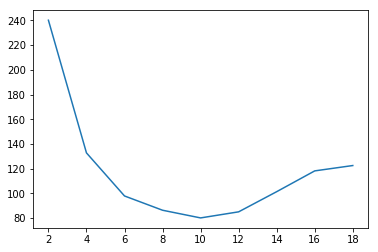

In [56]:
plt.plot(depths, mses)

In [57]:
best_model = models[depths.index(10)]

In [58]:
df = best_model.transform(Xte).toPandas()

In [60]:
df = df.set_index('date').sort_index()

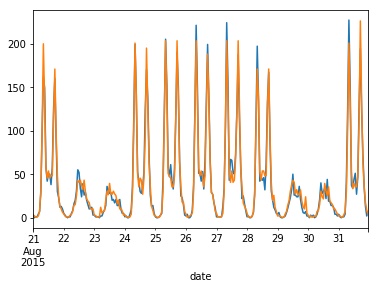

In [63]:
df.label.plot()
df.prediction.plot()

In [67]:
df['err'] = df.prediction - df.label

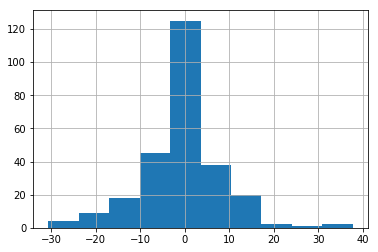

In [65]:
df.err.hist()

In [68]:
df['z'] = df.err / df.err.std()

In [69]:
df[np.abs(df.z) > 3]

,features,label,prediction,err,z
date,,,,,
2015-08-21 08:00:00,"[99.0, 218.0, 189.0, 166.0]",162,199.714286,37.714286,4.205761
2015-08-24 16:00:00,"[52.0, 17.0, 123.0, 122.0]",124,93.400000,-30.600000,-3.412402
2015-08-31 17:00:00,"[129.0, 19.0, 170.0, 196.0]",194,226.000000,32.000000,3.568524


In [70]:
from pyspark.ml.regression import GBTRegressor

In [ ]:
,